## 导入库

In [313]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls


# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical



import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

## 导入训练和测试数据

In [314]:
# This creates a pandas dataframe and assigns it to the titanic variable.
titanic = pd.read_csv("./input/train.csv")
# Print the first 5 rows of the dataframe.
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [315]:
titanic_test = pd.read_csv("./input/test.csv")
#transpose
titanic_test.head()
#note their is no Survived column here which is our target varible we are trying to predict

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [316]:
#shape command will give number of rows/samples/examples and number of columns/features/predictors in dataset
#(rows,columns)
titanic.shape

(891, 12)

In [317]:
#Describe gives statistical information about numerical columns in the dataset
titanic.describe()
#you can check from count if there are missing vales in columns, here age has got missing values

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [318]:
#info method provides information about dataset like 
#total values in each column, null/not null, datatype, memory occupied etc
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [319]:
# 看看有多少列有缺失值
null_columns=titanic.columns[titanic.isnull().any()]
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [320]:
# 同样看看测试集
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

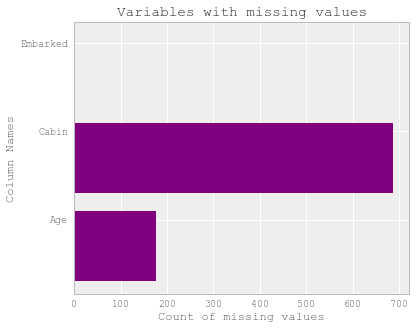

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

pd.options.display.mpl_style = 'default'
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(titanic[col].isnull().sum())
ind = np.arange(len(labels))
width=0.6
fig, ax = plt.subplots(figsize=(6,5))
rects = ax.barh(ind, np.array(values), color='purple')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_ylabel("Column Names")
ax.set_title("Variables with missing values");

## 可视化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000121D6461828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000121D6733C18>]], dtype=object)

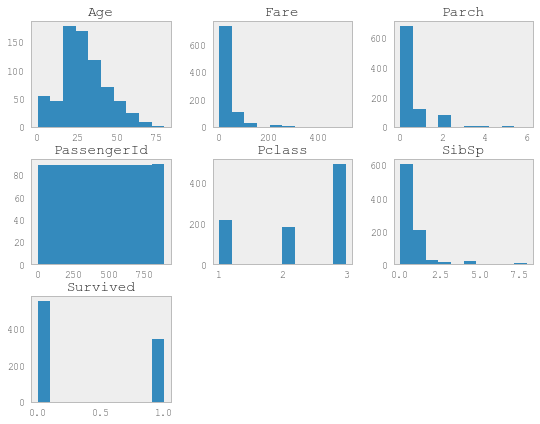

In [322]:
titanic.hist(bins=10,figsize=(9,7),grid=False)

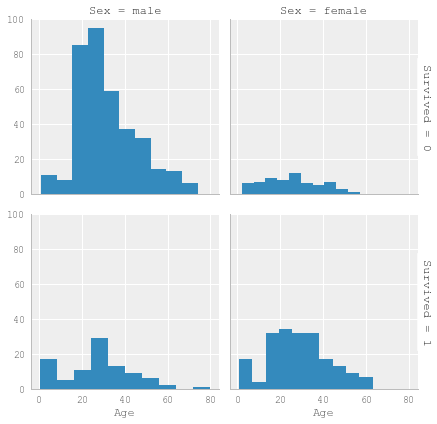

In [323]:
g = sns.FacetGrid(titanic, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist, "Age")

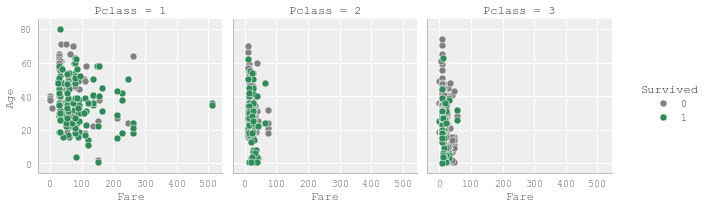

In [324]:
g = sns.FacetGrid(titanic, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()

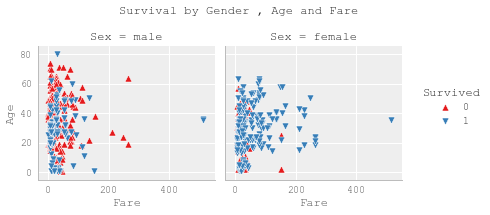

In [325]:
g = sns.FacetGrid(titanic, hue="Survived", col="Sex", margin_titles=True,
                palette="Set1",hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Gender , Age and Fare')

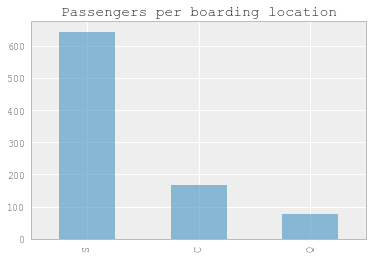

In [326]:
titanic.Embarked.value_counts().plot(kind='bar', alpha=0.55)
plt.title("Passengers per boarding location");

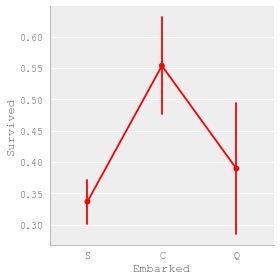

In [327]:
sns.factorplot(x = 'Embarked',y="Survived", data = titanic,color="r")

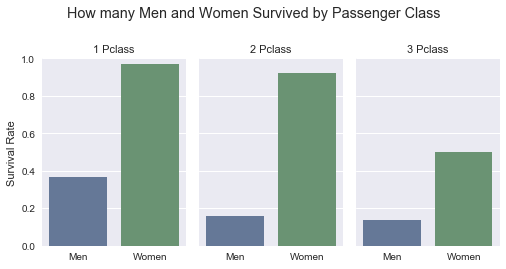

In [328]:
sns.set(font_scale=1)
g = sns.factorplot(x="Sex", y="Survived", col="Pclass",
                    data=titanic, saturation=.5,
                    kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Survival Rate")
    .set_xticklabels(["Men", "Women"])
    .set_titles("{col_name} {col_var}")
    .set(ylim=(0, 1))
    .despine(left=True))  
plt.subplots_adjust(top=0.8)
g.fig.suptitle('How many Men and Women Survived by Passenger Class')

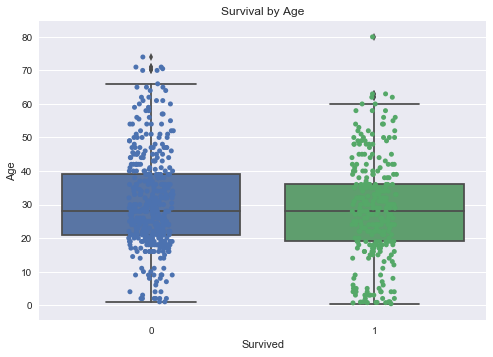

In [329]:
ax = sns.boxplot(x="Survived", y="Age", 
                data=titanic)
ax = sns.stripplot(x="Survived", y="Age",
                   data=titanic, jitter=True,
                   edgecolor="gray")
sns.plt.title("Survival by Age",fontsize=12)

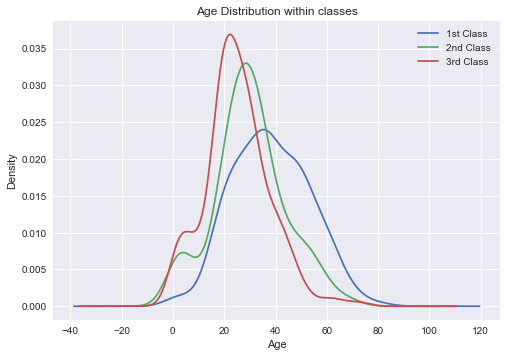

In [330]:
titanic.Age[titanic.Pclass == 1].plot(kind='kde')    
titanic.Age[titanic.Pclass == 2].plot(kind='kde')
titanic.Age[titanic.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

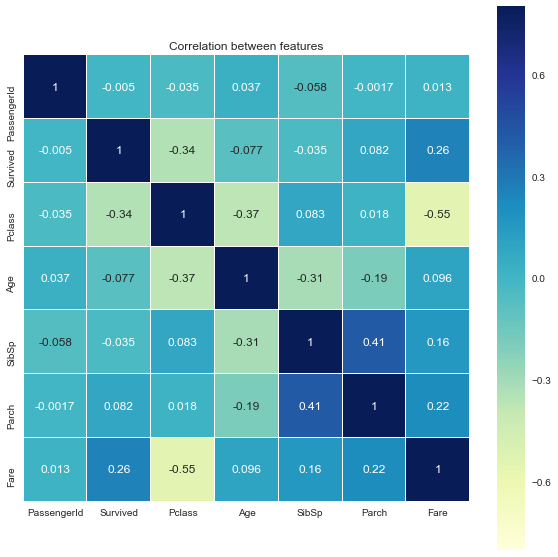

In [331]:
corr=titanic.corr()#["Survived"]
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

In [332]:
#correlation of features with target variable
titanic.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

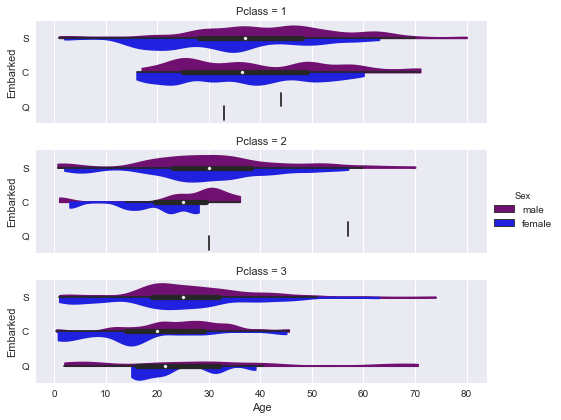

In [333]:
g = sns.factorplot(x="Age", y="Embarked",
                    hue="Sex", row="Pclass",
                    data=titanic[titanic.Embarked.notnull()],
                    orient="h", size=2, aspect=3.5, 
                   palette={'male':"purple", 'female':"blue"},
                    kind="violin", split=True, cut=0, bw=.2)

## 填补缺失值

### Embarked列

In [334]:
#Lets check which rows have null Embarked column
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


这两个缺失Embarked的行，Fare都是80，PClass都是1，通过可视化来猜测它们的值

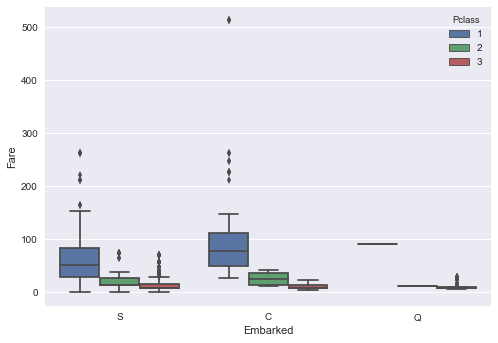

In [335]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=titanic)

In [336]:
titanic["Embarked"] = titanic["Embarked"].fillna('C')

In [337]:
#there is an empty fare column in test set
titanic_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Fare列

In [338]:
titanic_test[titanic_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [339]:
#we can replace missing value in fare by taking median of all fares of those passengers 
#who share 3rd Passenger class and Embarked from 'S' 
def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['Fare'].median()
#'S'
       #print(median_fare)
    df["Fare"] = df["Fare"].fillna(median_fare)
    return df

titanic_test=fill_missing_fare(titanic_test)

## 特征工程

#### 用Deck表示乘客在船上的位置

In [340]:
titanic["Deck"]=titanic.Cabin.str[0]
titanic_test["Deck"]=titanic_test.Cabin.str[0]
titanic["Deck"].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

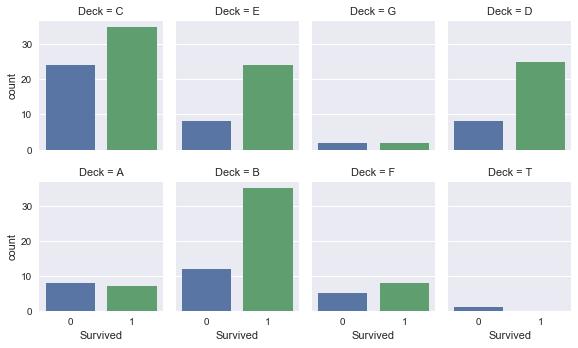

In [341]:
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=titanic[titanic.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8)

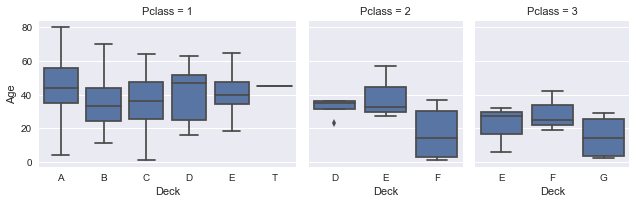

In [342]:
titanic = titanic.assign(Deck=titanic.Deck.astype(object)).sort_values(by="Deck")
g = sns.FacetGrid(titanic, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age")

### 家庭人口

In [343]:
# Create a family size variable including the passenger themselves
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]+1
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]+1
print(titanic["FamilySize"].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [344]:
# Discretize family size
titanic.loc[titanic["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic.loc[(titanic["FamilySize"] > 1)  &  (titanic["FamilySize"] < 5) , "FsizeD"] = 'small'
titanic.loc[titanic["FamilySize"] >4, "FsizeD"] = 'large'

titanic_test.loc[titanic_test["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic_test.loc[(titanic_test["FamilySize"] >1) & (titanic_test["FamilySize"] <5) , "FsizeD"] = 'small'
titanic_test.loc[titanic_test["FamilySize"] >4, "FsizeD"] = 'large'
print(titanic["FsizeD"].unique())
print(titanic["FsizeD"].value_counts())

['singleton' 'small' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


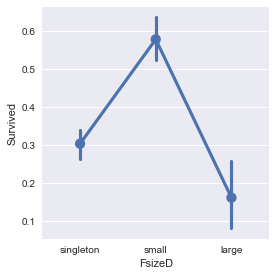

In [345]:
sns.factorplot(x="FsizeD", y="Survived", data=titanic)

### 名字长度...

[okay, short, good, long]
Categories (4, object): [good < long < okay < short]


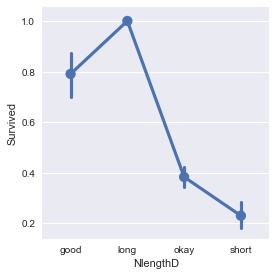

In [346]:
#Create feture for length of name 
# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))
#print(titanic["NameLength"].value_counts())

bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
titanic['NlengthD'] = pd.cut(titanic['NameLength'], bins, labels=group_names)
titanic_test['NlengthD'] = pd.cut(titanic_test['NameLength'], bins, labels=group_names)

sns.factorplot(x="NlengthD", y="Survived", data=titanic)
print(titanic["NlengthD"].unique())

### 称谓

In [347]:
import re

#A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

#Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))


#Add in the title column.
titanic["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
titanic.loc[titanic["Title"] == "Mlle", "Title"] = 'Miss'
titanic.loc[titanic["Title"] == "Ms", "Title"] = 'Miss'
titanic.loc[titanic["Title"] == "Mme", "Title"] = 'Mrs'
titanic.loc[titanic["Title"] == "Dona", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Lady", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Countess", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Capt", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Col", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Don", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Major", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Rev", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Sir", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Jonkheer", "Title"] = 'Rare Title'
titanic.loc[titanic["Title"] == "Dr", "Title"] = 'Rare Title'

#titanic.loc[titanic["Title"].isin(['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
#                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']), "Title"] = 'Rare Title'

#titanic[titanic['Title'].isin(['Dona', 'Lady', 'Countess'])]
#titanic.query("Title in ('Dona', 'Lady', 'Countess')")

titanic["Title"].value_counts()


titles = titanic_test["Name"].apply(get_title)
print(pd.value_counts(titles))

#Add in the title column.
titanic_test["Title"] = titles

# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Also reassign mlle, ms, and mme accordingly
titanic_test.loc[titanic_test["Title"] == "Mlle", "Title"] = 'Miss'
titanic_test.loc[titanic_test["Title"] == "Ms", "Title"] = 'Miss'
titanic_test.loc[titanic_test["Title"] == "Mme", "Title"] = 'Mrs'
titanic_test.loc[titanic_test["Title"] == "Dona", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Lady", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Countess", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Capt", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Col", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Don", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Major", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Rev", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Sir", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Jonkheer", "Title"] = 'Rare Title'
titanic_test.loc[titanic_test["Title"] == "Dr", "Title"] = 'Rare Title'

titanic_test["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Lady          1
Countess      1
Don           1
Capt          1
Ms            1
Mme           1
Sir           1
Jonkheer      1
Name: Name, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Ms          1
Dona        1
Name: Name, dtype: int64


Mr            240
Miss           79
Mrs            72
Master         21
Rare Title      6
Name: Title, dtype: int64

### Ticket

In [348]:
titanic["Ticket"].tail()

884    SOTON/OQ 392076
885             382652
886             211536
888         W./C. 6607
890             370376
Name: Ticket, dtype: object

In [349]:
titanic["TicketNumber"] = titanic["Ticket"].str.extract('(\d{2,})', expand=True)
titanic["TicketNumber"] = titanic["TicketNumber"].apply(pd.to_numeric)


titanic_test["TicketNumber"] = titanic_test["Ticket"].str.extract('(\d{2,})', expand=True)
titanic_test["TicketNumber"] = titanic_test["TicketNumber"].apply(pd.to_numeric)

In [350]:
#some rows in ticket column dont have numeric value so we got NaN there
titanic[titanic["TicketNumber"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5,E77,S,E,1,singleton,17,short,Mrs,NaN
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN,1,singleton,19,short,Mr,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN,1,singleton,28,okay,Mr,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN,1,singleton,31,okay,Mr,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN,1,singleton,19,short,Mr,NaN
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,NaN,1,singleton,24,okay,Mr,NaN


In [351]:
titanic.TicketNumber.fillna(titanic["TicketNumber"].median(), inplace=True)
titanic_test.TicketNumber.fillna(titanic_test["TicketNumber"].median(), inplace=True)

类别转换为数字

In [352]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelEnc=LabelEncoder()

cat_vars=['Embarked','Sex',"Title","FsizeD","NlengthD",'Deck']
titanic['Deck'].fillna('Z', inplace=True)
titanic_test['Deck'].fillna('Z', inplace=True)
for col in cat_vars:
    print(col)
    titanic[col]=labelEnc.fit_transform(titanic[col])
    titanic_test[col]=labelEnc.fit_transform(titanic_test[col])
titanic.head()

Embarked
Sex
Title
FsizeD
NlengthD
Deck


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
475,476,0,1,"Clifford, Mr. George Quincy",1,NaN,0,0,110465,52.0000,A14,2,0,1,1,27,2,2,110465.0
174,175,0,1,"Smith, Mr. James Clinch",1,56.0,0,0,17764,30.6958,A7,0,0,1,1,23,2,2,17764.0
209,210,1,1,"Blank, Mr. Henry",1,40.0,0,0,112277,31.0000,A31,0,0,1,1,16,3,2,112277.0
445,446,1,1,"Dodge, Master. Washington",1,4.0,0,2,33638,81.8583,A34,2,0,3,2,25,2,0,33638.0
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",1,56.0,0,0,13213,35.5000,A26,0,0,1,1,35,2,4,13213.0


### Age列
Age是个很有用的特征，所以不能轻易的把缺失值填成median/mean/mode，使用**Random Forest**预测age

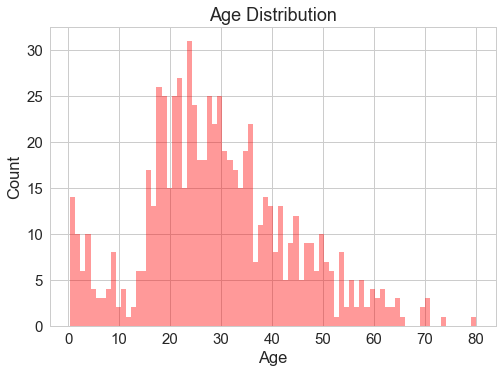

In [353]:
 with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(titanic["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")

In [355]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
                 'TicketNumber', 'Title','Pclass','FamilySize',
                 'FsizeD','NameLength',"NlengthD",'Deck']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [356]:
titanic=fill_missing_age(titanic)
titanic_test=fill_missing_age(titanic_test)

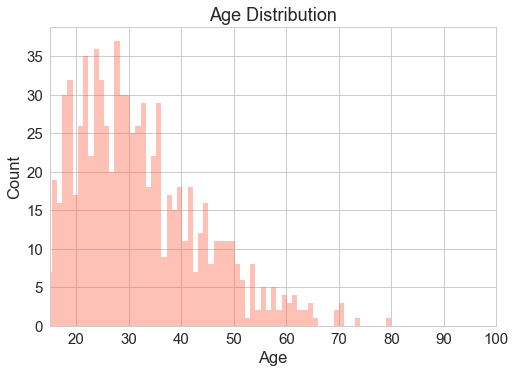

In [357]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(titanic["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")
    plt.xlim((15,100))

### 特征缩放
Age和Fare的范围和其他维度的不一样，所以先做特征缩放

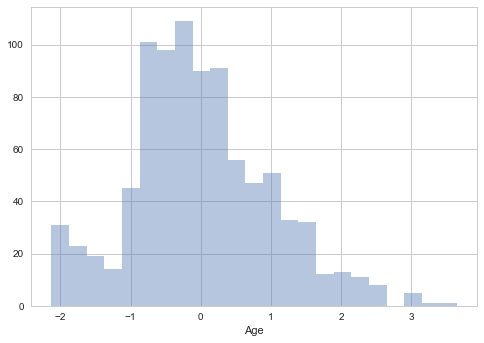

In [390]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(titanic[['Age', 'Fare']])
titanic[['Age', 'Fare']] = std_scale.transform(titanic[['Age', 'Fare']])


std_scale = preprocessing.StandardScaler().fit(titanic_test[['Age', 'Fare']])
titanic_test[['Age', 'Fare']] = std_scale.transform(titanic_test[['Age', 'Fare']])

sns.distplot(titanic['Age'], kde=False)

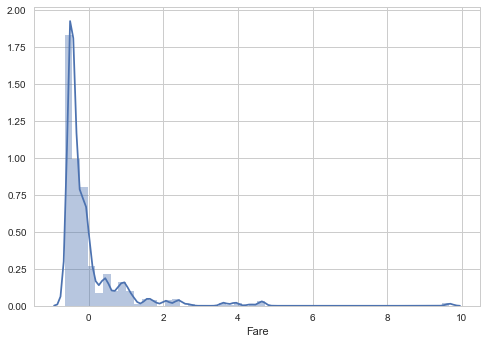

In [389]:
sns.distplot(titanic['Fare'])

In [394]:
#Correlation of features with target ¶
titanic.corr()["Survived"].sort_values(ascending=False)

Survived        1.000000
NameLength      0.332350
FsizeD          0.283810
Fare            0.257307
Parch           0.081629
FamilySize      0.016639
PassengerId    -0.005007
SibSp          -0.035322
Title          -0.071174
Age            -0.079061
TicketNumber   -0.096161
Embarked       -0.174199
Deck           -0.301116
NlengthD       -0.312234
Pclass         -0.338481
Sex            -0.543351
Name: Survived, dtype: float64

## 预测

### 线性回归

In [395]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age","SibSp", "Parch", "Fare",
              "Embarked","NlengthD", "FsizeD", "Title","Deck"]
target="Survived"
# Initialize our algorithm class
alg = LinearRegression()

# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []

In [396]:
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic[target].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [397]:
predictions = np.concatenate(predictions, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0


accuracy=sum(titanic["Survived"]==predictions)/len(titanic["Survived"])
accuracy

0.81144781144781142

### Logistic Regression

In [398]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

predictors = ["Pclass", "Sex", "Fare", "Embarked","Deck","Age",
              "FsizeD", "NlengthD","Title","Parch"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

scores = cross_val_score(lr, titanic[predictors], 
                                          titanic["Survived"],scoring='f1', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.749975244039


### Random Forest 

In [399]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict

import numpy as np
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, 
                            min_samples_leaf=1)
kf = KFold(titanic.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

predictions = cross_validation.cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],
                                          scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.751575270883


In [400]:
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck","TicketNumber"]
rf = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=9,min_samples_split=6, min_samples_leaf=4)
rf.fit(titanic[predictors],titanic["Survived"])
kf = KFold(titanic.shape[0], n_folds=5, random_state=1)
predictions = cross_validation.cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.765932636004


### Important features¶

(-1, 10)

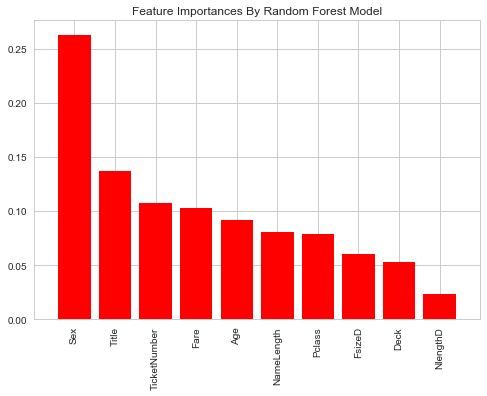

In [402]:
importances=rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
#predictors=titanic.columns
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])

### Gradient Boosting

(-1, 9)

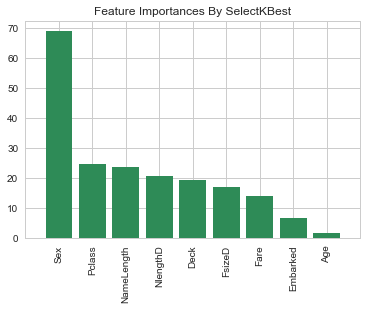

In [403]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import KFold
%matplotlib inline
import matplotlib.pyplot as plt
#predictors = ["Pclass", "Sex", "Age", "Fare",
 #             "FsizeD", "Embarked", "NlengthD","Deck","TicketNumber"]
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD", "FsizeD","NameLength","Deck","Embarked"]
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

indices = np.argsort(scores)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

plt.figure()
plt.title("Feature Importances By SelectKBest")
plt.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])

In [404]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
scores = cross_val_score(lr, titanic[predictors], titanic["Survived"], scoring='f1',cv=cv)
print(scores.mean())

0.747366422735


### AdaBoost

In [405]:
from sklearn.ensemble import AdaBoostClassifier
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","TicketNumber"]
adb=AdaBoostClassifier()
adb.fit(titanic[predictors],titanic["Survived"])
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
scores = cross_val_score(adb, titanic[predictors], titanic["Survived"], scoring='f1',cv=cv)
print(scores.mean())

0.766653326789


### Maximum Voting ensemble and Submission

In [407]:
predictions=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","NameLength","TicketNumber"]
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf), ('adb', adb)], voting='soft')
eclf1 = eclf1.fit(titanic[predictors], titanic["Survived"])
predictions=eclf1.predict(titanic[predictors])
predictions

test_predictions=eclf1.predict(titanic_test[predictors])

test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)